TCLab version 0.4.9
Simulated TCLab
LED On


<Figure size 432x288 with 0 Axes>

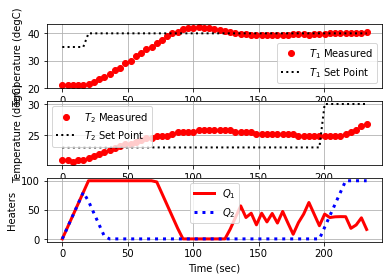

Shutting down


In [10]:
# import tclab
from tclab import TCLabModel as TCLab
import numpy as np
import time
import matplotlib.pyplot as plt
from gekko import GEKKO

# Connect to Arduino
a = TCLab()

# Get Version
# print(a.version)

# Turn LED on
print('LED On')
a.LED(100)

# Run time in minutes
run_time = 3.0

# Number of cycles with 3 second intervals
loops = int(20.0*run_time)
tm = np.zeros(loops)

# Temperature (K)
T1 = np.ones(loops) * a.T1 # temperature (degC)
T1mhe = np.ones(loops) * a.T1 # temperature (degC)
Tsp1 = np.ones(loops) * 35.0 # set point (degC)
T2 = np.ones(loops) * a.T2 # temperature (degC)
T2mhe = np.ones(loops) * a.T1 # temperature (degC)
Tsp2 = np.ones(loops) * 23.0 # set point (degC)

# Set point changes
Tsp1[5:] = 40.0
Tsp1[120:] = 35.0
Tsp1[200:] = 50.0

Tsp2[50:] = 30.0
Tsp2[100:] = 35.0
Tsp2[150:] = 30.0
Tsp2[250:] = 35.0

# heater values
Q1s = np.ones(loops) * 0.0
Q2s = np.ones(loops) * 0.0

#########################################################
# Initialize Models
#########################################################
# Fixed Parameters
mass = 4.0/1000.0    # kg
Cp = 0.5*1000.0      # J/kg-K    
A = 10.0/100.0**2    # Area not between heaters in m^2
As = 2.0/100.0**2    # Area between heaters in m^2
eps = 0.9            # Emissivity
sigma = 5.67e-8      # Stefan-Boltzmann

# initialize MHE and MPC
# use remote=True for MacOS
mhe = GEKKO(name='tclab-mhe',remote=False)
mpc = GEKKO(name='tclab-mpc',remote=False)

# create 2 models (MHE and MPC) in loop
for m in [mhe,mpc]:
    # Adjustable Parameters
    # heat transfer (W/m2-K)
    m.U = m.FV(value=2.76,lb=1.0,ub=5.0)
    # time constant (sec)
    m.tau = m.FV(value=8.89,lb=5,ub=15)
    # W / % heater
    m.alpha1 = m.FV(value=0.005,lb=0.002,ub=0.010)
    # W / % heater
    m.alpha2 = m.FV(value=0.0026,lb=0.001,ub=0.005)
    # degC
    m.Ta = m.FV(value=22.8,lb=15.0,ub=25.0)        

    # Manipulated variables
    m.Q1 = m.MV(value=0)
    m.Q1.LOWER = 0.0
    m.Q1.UPPER = 100.0
    m.Q2 = m.MV(value=0)
    m.Q2.LOWER = 0.0
    m.Q2.UPPER = 100.0

    # Controlled variables
    m.TC1 = m.CV(value=T1[0])
    m.TC2 = m.CV(value=T2[0])

    # State variables
    m.TH1 = m.SV(value=T1[0])
    m.TH2 = m.SV(value=T2[0])

    # Heater temperatures
    m.T1i = m.Intermediate(m.TH1+273.15)
    m.T2i = m.Intermediate(m.TH2+273.15)
    m.TaK = m.Intermediate(m.Ta+273.15)

    # Heat transfer between two heaters
    m.Q_C12 = m.Intermediate(m.U*As*(m.T2i-m.T1i)) # Convective
    m.Q_R12 = m.Intermediate(eps*sigma*As\
                                 *(m.T2i**4-m.T1i**4)) # Radiative

    # Semi-fundamental correlations (energy balances)
    m.Equation(mass*Cp*m.TH1.dt() == m.U*A*(m.TaK-m.T1i) \
                  + eps * sigma * A * (m.TaK**4 - m.T1i**4) \
                  + m.Q_C12 + m.Q_R12 \
                  + m.alpha1 * m.Q1)

    m.Equation(mass*Cp*m.TH2.dt() == m.U*A*(m.TaK-m.T2i) \
                  + eps * sigma * A * (m.TaK**4 - m.T2i**4) \
                  - m.Q_C12 - m.Q_R12 \
                  + m.alpha2 * m.Q2)

    # Empirical correlations (lag equations to emulate conduction)
    m.Equation(m.tau * m.TC1.dt() == -m.TC1 + m.TH1)
    m.Equation(m.tau * m.TC2.dt() == -m.TC2 + m.TH2)

##################################################################
# Configure MHE
# 120 second time horizon, steps of 4 sec
mhe.time = np.linspace(0,120,31)
#mhe.server = 'http://127.0.0.1' # solve locally

# FV tuning
# update FVs with estimator
mhe.U.STATUS = 1
mhe.tau.STATUS = 0
mhe.alpha1.STATUS = 0
mhe.alpha2.STATUS = 0
mhe.Ta.STATUS = 0
# FVs are predicted, not measured
mhe.U.FSTATUS = 0
mhe.tau.FSTATUS = 0
mhe.alpha1.FSTATUS = 0
mhe.alpha2.FSTATUS = 0
mhe.Ta.FSTATUS = 0

# MV tuning
mhe.Q1.STATUS = 0  # not optimized in estimator
mhe.Q1.FSTATUS = 0 # receive heater measurement

mhe.Q2.STATUS = 0  # not optimized in estimator
mhe.Q2.FSTATUS = 0 # receive heater measurement

# CV tuning
mhe.TC1.STATUS = 0     # not needed for estimator
mhe.TC1.FSTATUS = 1    # receive measurement

mhe.TC2.STATUS = 0     # not needed for estimator
mhe.TC2.FSTATUS = 1    # receive measurement

# Global Options
mhe.options.IMODE   = 5 # MHE
mhe.options.EV_TYPE = 2 # Objective type
mhe.options.NODES   = 3 # Collocation nodes
mhe.options.SOLVER  = 3 # 1=APOPT, 3=IPOPT

##################################################################
# Configure MPC
# 60 second time horizon, 4 sec cycle time, non-uniform
mpc.time = [0,4,8,12,15,20,25,30,35,40,50,60,70,80,90]
#mpc.server = 'http://127.0.0.1' # solve locally

# FV tuning
# don't update FVs with controller
mpc.U.STATUS = 0
mpc.tau.STATUS = 0
mpc.alpha1.STATUS = 0
mpc.alpha2.STATUS = 0
mpc.Ta.STATUS = 0
# controller uses measured values from estimator
mpc.U.FSTATUS = 1
mpc.tau.FSTATUS = 1
mpc.alpha1.FSTATUS = 1
mpc.alpha2.FSTATUS = 1
mpc.Ta.FSTATUS = 1

# MV tuning
mpc.Q1.STATUS = 1  # use to control temperature
mpc.Q1.FSTATUS = 0 # no feedback measurement
mpc.Q1.DMAX = 20.0
mpc.Q1.DCOST = 0.1
mpc.Q1.COST = 0.0
mpc.Q1.DCOST = 0.0

mpc.Q2.STATUS = 1  # use to control temperature
mpc.Q2.FSTATUS = 0 # no feedback measurement
mpc.Q2.DMAX = 20.0
mpc.Q2.DCOST = 0.1
mpc.Q2.COST = 0.0
mpc.Q2.DCOST = 0.0

# CV tuning
mpc.TC1.STATUS = 1     # minimize error with setpoint range
mpc.TC1.FSTATUS = 1    # receive measurement
mpc.TC1.TR_INIT = 2    # reference trajectory
mpc.TC1.TAU = 10       # time constant for response

mpc.TC2.STATUS = 1     # minimize error with setpoint range
mpc.TC2.FSTATUS = 1    # receive measurement
mpc.TC2.TR_INIT = 2    # reference trajectory
mpc.TC2.TAU = 10       # time constant for response

# Global Options
mpc.options.IMODE   = 6 # MPC
mpc.options.CV_TYPE = 1 # Objective type
mpc.options.NODES   = 3 # Collocation nodes
mpc.options.SOLVER  = 3 # 1=APOPT, 3=IPOPT
##################################################################

# Create plot
plt.figure()
plt.ion()
plt.show()

# Main Loop
start_time = time.time()
prev_time = start_time
try:
    for i in range(1,loops):
        # Sleep time
        sleep_max = 4.0
        sleep = sleep_max - (time.time() - prev_time)
        if sleep>=0.01:
            time.sleep(sleep)
        else:
            print('Warning: cycle time too fast')
            print('Requested: ' + str(sleep_max))
            print('Actual: ' + str(time.time() - prev_time))                  
            time.sleep(0.01)

        # Record time and change in time
        t = time.time()
        dt = t - prev_time
        prev_time = t
        tm[i] = t - start_time

        # Read temperatures in degC
        T1[i] = a.T1
        T2[i] = a.T2

        #################################
        ### Moving Horizon Estimation ###
        #################################
        # Measured values
        mhe.Q1.MEAS = Q1s[i-1]
        mhe.Q2.MEAS = Q2s[i-1]
        # Temperatures from Arduino
        mhe.TC1.MEAS = T1[i]
        mhe.TC2.MEAS = T2[i]
        # solve MHE
        mhe.solve(disp=False)
        # Parameters from MHE to MPC (if successful)
        if (mhe.options.APPSTATUS==1):
            # FVs
            mpc.U.MEAS = mhe.U.NEWVAL
            mpc.tau.MEAS = mhe.tau.NEWVAL
            mpc.alpha1.MEAS = mhe.alpha1.NEWVAL
            mpc.alpha2.MEAS = mhe.alpha2.NEWVAL
            mpc.Ta.MEAS = mhe.Ta.NEWVAL
            # CVs
            T1mhe[i] = mhe.TC1.MODEL
            T2mhe[i] = mhe.TC2.MODEL
        else:
            print("MHE failed to solve, don't update parameters")
            T1mhe[i] = np.nan
            T2mhe[i] = np.nan

        #################################
        ### Model Predictive Control  ###
        #################################
        # Temperatures from Arduino
        mpc.TC1.MEAS = T1[i]
        mpc.TC2.MEAS = T2[i]
        # input setpoint with deadband +/- DT
        DT = 0.2
        mpc.TC1.SPHI = Tsp1[i] + DT
        mpc.TC1.SPLO = Tsp1[i] - DT
        mpc.TC2.SPHI = Tsp2[i] + DT
        mpc.TC2.SPLO = Tsp2[i] - DT
        # solve MPC
        mpc.solve(disp=False)
        # test for successful solution
        if (mpc.options.APPSTATUS==1):
            # retrieve the first Q value
            Q1s[i] = mpc.Q1.NEWVAL
            Q2s[i] = mpc.Q2.NEWVAL
        else:
            # not successful, set heater to zero
            print("MPC failed to solve, heaters off")
            Q1s[i] = 0  
            Q2s[i] = 0

        # Write output (0-100)
        a.Q1(Q1s[i])
        a.Q2(Q2s[i])

        # Plot
        plt.clf()
        ax=plt.subplot(3,1,1)
        ax.grid()
        plt.plot(tm[0:i],T1[0:i],'ro',label=r'$T_1$ Measured')
        plt.plot(tm[0:i],Tsp1[0:i],'k:',lw=2,label=r'$T_1$ Set Point')
        plt.ylabel('Temperature (degC)')
        plt.legend(loc='best')
        ax=plt.subplot(3,1,2)
        ax.grid()
        plt.plot(tm[0:i],T2[0:i],'ro',label=r'$T_2$ Measured')
        plt.plot(tm[0:i],Tsp2[0:i],'k:',lw=2,label=r'$T_2$ Set Point')
        plt.ylabel('Temperature (degC)')
        plt.legend(loc='best')
        ax=plt.subplot(3,1,3)
        ax.grid()
        plt.plot(tm[0:i],Q1s[0:i],'r-',lw=3,label=r'$Q_1$')
        plt.plot(tm[0:i],Q2s[0:i],'b:',lw=3,label=r'$Q_2$')
        plt.ylabel('Heaters')
        plt.xlabel('Time (sec)')
        plt.legend(loc='best')
        plt.draw()
    plt.pause(0.05)

    # Turn off heaters
    a.Q1(0)
    a.Q2(0)
    print('Shutting down')

# Allow user to end loop with Ctrl-C          
except KeyboardInterrupt:
    # Disconnect from Arduino
    a.Q1(0)
    a.Q2(0)
    print('Shutting down')
    a.close()

# Make sure serial connection still closes when there's an error
except:          
    # Disconnect from Arduino
    a.Q1(0)
    a.Q2(0)
    print('Error: Shutting down')
    a.close()
    raise

1. This lab combines the parameter estimation and predictive control in a unified approach. How
does the temperature control perform relative to Lab G (Nonlinear MPC) where the parameter
estimation is performed before the controller is implemented?

Control looks quite a bit better actually. In lab G, the outputs wandered a little bit. This makes sense though. Performance increase at the cost of increased computation time. 

2. How does MHE affect MPC when there is overly aggressive tracking of the measured
temperatures with large parameter changes?

It looks like it make it difficult to settle down. The model is constantly changing, so mpc is a littler jittery. 


3. How does MPC affect MHE when there are no set point changes for a sustained period of time?

It seems like the MHE changes parameters when the set points change mostly. When it sits still, the values converge and stay there. 
